<a href="https://colab.research.google.com/github/sachinprabhu007/NLP-programs/blob/master/word2vec_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Online Retail.xlsx to Online Retail (1).xlsx
User uploaded file "Online Retail.xlsx" with length 23715344 bytes


In [4]:
df = pd.read_excel('/content/Online Retail (1).xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
#check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [0]:
#removing missing values
df.dropna(inplace=True)

In [0]:
#data preparation

df['StockCode'] = df['StockCode'].astype(str)

In [9]:
customers = df['CustomerID'].unique().tolist()
len(customers)

4372

In [0]:
#shuffle customer ID's

random.shuffle(customers)

#extract 90% of customer ID's

customers_train = [customers[i] for i in range(round(0.9 * len(customers)))]

#split data into train and validation data
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]


In [12]:
#list to capture purchase history of the customers

purchases_train  = []

#populate the list with the product codes
for i in tqdm(customers_train):
  temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
  purchases_train.append(temp)

100%|██████████| 3935/3935 [00:05<00:00, 707.28it/s]


In [31]:
 #list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 873.11it/s]


In [14]:
#build word2vec embedding for products 

#train word2vec model

model = Word2Vec(window = 10, sg=1, hs=0,
                  negative = 10, #for negative sampling
                 alpha = 0.03 , min_alpha = 0.0007,
                 seed = 14
                )
model.build_vocab(purchases_train, progress_per = 200)

model.train(purchases_train, total_examples = model.corpus_count,
            epochs = 10, report_delay = 1)


(3631883, 3669740)

In [0]:
model.init_sims(replace=True)

In [16]:
print(model)

Word2Vec(vocab=3171, size=100, alpha=0.03)


In [17]:
#extract all vectors
X = model[model.wv.vocab]
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(3171, 100)

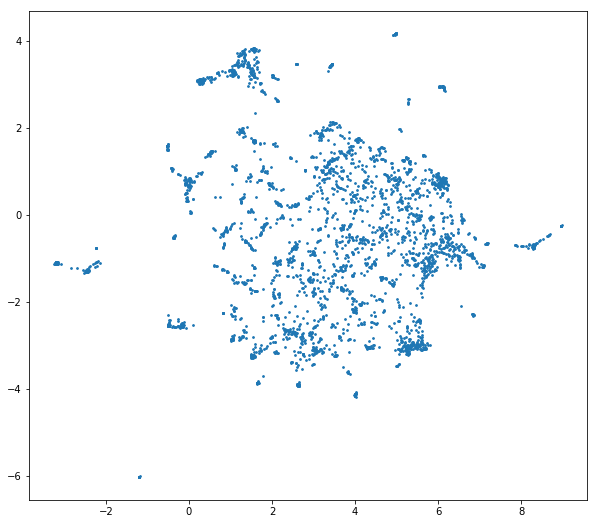

In [19]:
#visualize word2vec Embeddings

import umap

cluster_embedding = umap.UMAP(n_neighbors = 30, min_dist =0.0,
                              n_components = 2, random_state = 42).fit_transform(X)
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0],cluster_embedding[:,1],s=3,cmap='Spectral')


In [21]:
#start recommending products 

products = train_df[["StockCode", "Description"]]

#remove duplicates

products.drop_duplicates(inplace=True,subset='StockCode',keep="last")

#create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [0]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms    

In [27]:
similar_products(model['90019A'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('BLUE MURANO TWIST BRACELET', 0.7624731063842773),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.7546048164367676),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7537829279899597),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7530564069747925),
 ('RASPBERRY ANT COPPER FLOWER NECKLAC', 0.7517307996749878),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7445203065872192)]

In [0]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [32]:
len(purchases_val[0])

196

In [33]:
aggregate_vectors(purchases_val[0]).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(100,)

In [34]:
similar_products(aggregate_vectors(purchases_val[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('SET OF 3 REGENCY CAKE TINS', 0.7049392461776733),
 ('JAM MAKING SET WITH JARS', 0.6835497617721558),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6790276765823364),
 ('SPOTTY BUNTING', 0.6652057766914368),
 ('JAM MAKING SET PRINTED', 0.6599777936935425),
 ('PARTY BUNTING', 0.6557847261428833)]

In [35]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('SET OF 3 REGENCY CAKE TINS', 0.6656144261360168),
 ('PACK OF SIX LED TEA LIGHTS', 0.6472045183181763),
 ("PAPER CHAIN KIT 50'S CHRISTMAS ", 0.6385523080825806),
 ('VINTAGE CHRISTMAS STOCKING ', 0.632905125617981),
 ('MISTLETOE HEART WREATH GREEN', 0.6299018859863281),
 ("BOX OF 6 MINI 50'S CRACKERS", 0.6286841630935669)]

In [0]:
#source : https://www.analyticsvidhya.com/blog/2019/07/how-to-build-recommendation-system-word2vec-python/
